# Ashley, please read this first

---

I've outlined the steps for the HAR-RV forecast in the notebook. Please let me know if you have any questions or if you need any clarification.

The cleaned data is in `SPY_1min_clean.csv`.

In [219]:
# Required packages
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime 
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

### MIHIR MESSING AROUND WITH CURR DATA

In [220]:
ticker = "SPY"

We import our intraday 1 minute data of SPY that ranges from ***2008-01-22*** to ***2023-09-29***.

In [221]:
# Import & clean intraday data
df = pd.read_csv("SPY1min_clean.csv", parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df


,open,high,low,close,volume,barCount,average
date,,,,,,,
2008-01-22 07:30:00,126.4500,126.8200,126.0000,126.6700,30987,4541,126.283
2008-01-22 07:31:00,126.6700,127.1700,126.3900,127.1200,20111,3125,126.958
2008-01-22 07:32:00,127.1000,127.1300,126.7100,126.7800,11979,2074,126.922
2008-01-22 07:33:00,126.7600,126.9000,126.5300,126.5400,8017,1350,126.675
2008-01-22 07:34:00,126.5400,127.1800,126.5400,126.7800,11967,1253,126.730
...,...,...,...,...,...,...,...
2023-09-29 19:22:00,427.5800,427.5800,427.5500,427.5500,236,0,0.000
2023-09-29 19:24:00,427.5201,427.5201,427.5200,427.5200,1319,0,0.000
2023-09-29 19:39:00,427.6199,427.6199,427.6199,427.6199,1000,0,0.000


We resample the 1 minute data to a 5 minute timeframe as [Andersen et al (2000)](https://ssrn.com/abstract=267791) argue this sampling interval is optimal for a liquid market.

In [222]:
# Resample 1min to 5min
sample = '5T'
alt_df = df.resample(sample).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
alt_df.dropna(inplace = True)
alt_df

,open,high,low,close,volume
date,,,,,
2008-01-22 07:30:00,126.4500,127.1800,126.0000,126.7800,83061
2008-01-22 07:35:00,126.8000,127.8900,126.1200,127.6500,69696
2008-01-22 07:40:00,127.5800,128.2600,127.0000,128.1000,78193
2008-01-22 07:45:00,128.0800,129.3000,128.0300,129.0300,90224
2008-01-22 07:50:00,129.0200,129.8600,128.9200,129.2500,113235
...,...,...,...,...,...
2023-09-29 19:05:00,427.5500,427.5500,427.5300,427.5500,473
2023-09-29 19:10:00,427.5300,427.6100,427.5300,427.6100,1403
2023-09-29 19:20:00,427.5800,427.5800,427.5200,427.5200,1555


In [223]:
SPY_daily = alt_df[["volume"]]
SPY_daily 

,volume
date,
2008-01-22 07:30:00,83061
2008-01-22 07:35:00,69696
2008-01-22 07:40:00,78193
2008-01-22 07:45:00,90224
2008-01-22 07:50:00,113235
...,...
2023-09-29 19:05:00,473
2023-09-29 19:10:00,1403
2023-09-29 19:20:00,1555


Now that we have the data, there are 4 major steps to follow:
- Compute daily realized volatilty from intraday data.
- Average the values over 5 periods to get rolling weekly realized volatility and 22 periods for monthly realized volatility.
- Estimate the HAR-RV coefficients.
- Measure the performance of the model.

We start by computing the daily RV, based on $n$ intraday prices:
$RV^d_t =  \sqrt {\sum_{j=0}^{n-1} r^2_{t-j\Delta}}$

Where:
- $r_{t-j\Delta} = \Delta \left(p_{t-j} - p_{t-(j+1)}\right)$
- $\Delta = 1d/n_{periods}$
- $p_t$ is the price at time $t$
- $n$ is the number of 5 minute bars in a trading day

In [225]:
alt_df

,open,high,low,close,volume
date,,,,,
2008-01-22 07:30:00,126.4500,127.1800,126.0000,126.7800,83061
2008-01-22 07:35:00,126.8000,127.8900,126.1200,127.6500,69696
2008-01-22 07:40:00,127.5800,128.2600,127.0000,128.1000,78193
2008-01-22 07:45:00,128.0800,129.3000,128.0300,129.0300,90224
2008-01-22 07:50:00,129.0200,129.8600,128.9200,129.2500,113235
...,...,...,...,...,...
2023-09-29 19:05:00,427.5500,427.5500,427.5300,427.5500,473
2023-09-29 19:10:00,427.5300,427.6100,427.5300,427.6100,1403
2023-09-29 19:20:00,427.5800,427.5800,427.5200,427.5200,1555


# From this point on, working with live data #
---

Using yfinance, I'm pulling last 60 days of data. We DO NOT use this data for training or for testing, because we are doing meme stock era. This is purely incase we decide to do it in the future.

In [227]:
import datetime as dt
import yfinance as yf

### WORKING CODE THAT PULLS FROM YF AND PROCESSES IN THE WAY WE WANT ###

# pull initial data from yfinance
start_date = dt.datetime.today() - dt.timedelta(days=59)
curr_data = yf.download("SPY", period="1y", interval="5m", start=start_date)
curr_data = curr_data[curr_data['Volume'] != 0]
curr_data = curr_data.dropna()

# clean 5m interval data to process best for har-rv
curr_data_cleaned = curr_data.rename(columns={"Close": "close", "Volume": "volume", "Open": "open", "High": "high", "Low": "low"})
curr_data_cleaned.columns = curr_data_cleaned.columns.droplevel("Ticker")
curr_data_cleaned.index = curr_data_cleaned.index.tz_convert("America/New_York").tz_localize(None)
curr_data_cleaned.index.name = "date"
curr_data_cleaned.columns.name = None

curr_data_cleaned

[*********************100%***********************]  1 of 1 completed


,close,high,low,open,volume
date,,,,,
2025-10-17 09:30:00,660.489990,660.580017,658.715027,659.500000,7820966
2025-10-17 09:35:00,659.815002,661.359985,659.650024,660.500000,2494186
2025-10-17 09:40:00,658.650024,660.039978,658.229980,659.789978,1823741
2025-10-17 09:45:00,660.109985,660.650024,658.349976,658.640015,2025346
2025-10-17 09:50:00,661.690002,662.020020,660.039978,660.109985,2035487
...,...,...,...,...,...
2025-12-12 15:35:00,680.335022,681.130005,680.070007,681.020020,1645347
2025-12-12 15:40:00,680.839722,681.140015,680.320007,680.340027,1795690
2025-12-12 15:45:00,681.359985,681.869995,680.729980,680.840027,2339018


This is bad practice, but basically I just did the entire period and return calculations in one cell

In [261]:
### WORKIGN HAR RV CALC ###

curr_df = curr_data_cleaned
curr_df["D"] = curr_df.index.date
n_periods = curr_df.pivot_table(index = ["D"], aggfunc = 'size').values
curr_df.loc[curr_df["D"] != curr_df["D"].shift(), "Per"] = n_periods
curr_df.fillna(method = 'ffill', inplace = True)
curr_df["Ret"] = np.where(curr_df["D"] == curr_df["D"].shift(), ( (curr_df["close"]-curr_df["close"].shift()) * 1/curr_df["Per"] ) **2, np.nan)
curr_rv = curr_df.groupby("D")["Ret"].agg(np.sum).to_frame()
curr_rv.columns = ["RV_daily"]
curr_rv["RV_daily"] = np.sqrt(curr_rv["RV_daily"])
date = str(curr_rv["RV_daily"].idxmax())
curr_df["close"].loc[date]
date = str(curr_rv["RV_daily"].idxmax())

curr_rv

,RV_daily
D,
2025-10-17,0.076698
2025-10-20,0.030339
2025-10-21,0.036624
2025-10-22,0.064399
2025-10-23,0.040271
2025-10-24,0.026067
2025-10-27,0.021126
2025-10-28,0.026282
2025-10-29,0.078473


this plot here will pick the day with the highest vol as calculated by the model, and then plot the price to ensure that it **actually** is the day with the highest vol

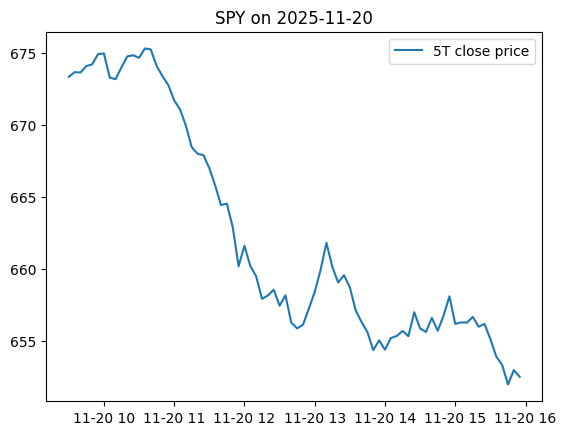

In [262]:
## used to see highest vol day
plt.plot(curr_df["close"].loc[date], label = f"{sample} close price")
plt.title(f"{ticker} on {date}")
plt.legend()
plt.show()

In [264]:
# get volume data

SPY_daily = alt_df[["volume"]]
SPY_daily_current = curr_df[["volume"]]
SPY_daily


,volume
date,
2008-01-22 07:30:00,83061
2008-01-22 07:35:00,69696
2008-01-22 07:40:00,78193
2008-01-22 07:45:00,90224
2008-01-22 07:50:00,113235
...,...
2023-09-29 19:05:00,473
2023-09-29 19:10:00,1403
2023-09-29 19:20:00,1555


In [267]:
# Compute number of periods/day
# alt_df = curr_data_cleaned
alt_df["D"] = alt_df.index.date
n_periods = alt_df.pivot_table(index = ["D"], aggfunc = 'size').values
stats.describe(n_periods)

DescribeResult(nobs=np.int64(3598), minmax=(np.int64(42), np.int64(193)), mean=np.float64(92.78265703168427), variance=np.float64(1440.2735718095016), skewness=np.float64(2.1524091126386713), kurtosis=np.float64(2.7376159372911344))

We then compute $r^2_{t-j\Delta}$ for all days. (NOW I AM DOING RETURN CALCULATIONS FOR HISTORICAL DATA)

In [268]:
alt_df.loc[alt_df["D"] != alt_df["D"].shift(), "Per"]  = n_periods
alt_df.fillna(method = 'ffill', inplace = True)

alt_df["Ret"] = np.where(alt_df["D"] == alt_df["D"].shift(),
                    ( (alt_df["close"]-alt_df["close"].shift()) * 1/alt_df["Per"] ) **2, np.nan)

In [269]:
# Perform the sum grouped by days.
rv = alt_df.groupby("D")["Ret"].agg(np.sum).to_frame()

In [270]:
# Add sqrt to get Realized-Vol
rv.columns = ["RV_daily"]
rv["RV_daily"] = np.sqrt(rv["RV_daily"])

In [271]:
rv

,RV_daily
D,
2008-01-22,0.042742
2008-01-23,0.043714
2008-01-24,0.029548
2008-01-25,0.026224
2008-01-28,0.025124
...,...
2023-09-25,0.019415
2023-09-26,0.016861
2023-09-27,0.019797


In [272]:
date = str(rv["RV_daily"].idxmax())
df["close"].loc[date]

date
2020-03-12 07:30:00    256.32
2020-03-12 07:31:00    256.40
2020-03-12 07:32:00    256.08
2020-03-12 07:33:00    255.66
2020-03-12 07:34:00    255.29
                        ...  
2020-03-12 13:55:00    251.41
2020-03-12 13:56:00    250.11
2020-03-12 13:57:00    250.18
2020-03-12 13:58:00    249.01
2020-03-12 13:59:00    248.08
Name: close, Length: 390, dtype: float64

same plot as earlier, just for historical data

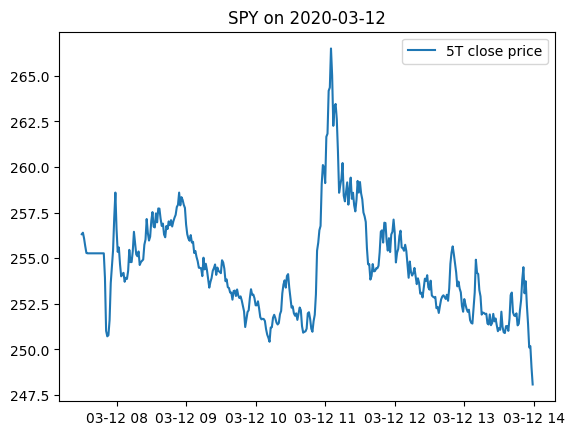

In [273]:
# Check what day in the dataset had the highest realized vol
date = str(rv["RV_daily"].idxmax())
plt.plot(df["close"].loc[date], label = f"{sample} close price")
plt.title(f"{ticker} on {date}")
plt.legend()
plt.show()

We can compute the weekly and monthly RV with:
- Weekly : $RV^w_t = \frac{1}{5} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1w}\right)$
- Monthly : $RV^m_t = \frac{1}{21} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1m}\right)$

In [274]:
# Compute weekly and monthly RV.  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

curr_rv["RV_weekly"] = curr_rv["RV_daily"].rolling(5).mean()
curr_rv["RV_monthly"] = curr_rv["RV_daily"].rolling(21).mean()
curr_rv.dropna(inplace = True)

## BY THIS POINT ##
---
We have RV daily, monthly, and yearly for both the current past 60 days and the historical data set (from 2008 to 2023) 

In [278]:
# replace this with "rv" to see historical, "curr_rv" to see current

curr_rv

,RV_daily,RV_weekly,RV_monthly
D,,,
2025-11-14,0.079866,0.053195,0.050078
2025-11-17,0.072962,0.059438,0.049901
2025-11-18,0.089837,0.070309,0.052734
2025-11-19,0.079111,0.078095,0.054757
2025-11-20,0.113978,0.087151,0.057118
2025-11-21,0.102117,0.091601,0.060063
2025-11-24,0.050077,0.087024,0.061206
2025-11-25,0.082789,0.085614,0.064143
2025-11-26,0.046043,0.079001,0.065084


In [279]:
SPY_daily = alt_df[["volume"]]
SPY_daily_curr = curr_df[["volume"]]

In [280]:
SPY_daily = SPY_daily.resample('D')['volume'].sum().reset_index()
SPY_daily_curr = SPY_daily_curr.resample('D')['volume'].sum().reset_index()

In [281]:
SPY_daily = SPY_daily.set_index("date")
SPY_daily_curr = SPY_daily_curr.set_index("date")

### Daily ###

This was for making sure that we have proper volume data for each day

In [282]:
# "SPY_daily" for historical data
# "SPY_daily_curr" for current data

SPY_daily_curr

,volume
date,
2025-10-17,84852579
2025-10-18,0
2025-10-19,0
2025-10-20,52893074
2025-10-21,50784839
2025-10-22,74191348
2025-10-23,57429074
2025-10-24,59117252
2025-10-25,0


In [284]:
#Add IV & Volume variables

rv["SPY_volume"] = SPY_daily.loc[rv.index]
curr_rv["SPY_volume"] = SPY_daily_curr.loc[curr_rv.index]

In [250]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])
print("p-value for SPY Volume:",adf(rv["SPY_volume"].values)[1])

print("p-value for daily RV:", adf(curr_rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(curr_rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(curr_rv["RV_monthly"].values)[1])
print("p-value for SPY Volume:",adf(curr_rv["SPY_volume"].values)[1])

p-value for daily RV: 2.4172795777317743e-10
p-value for weekly RV: 2.520042741979913e-07
p-value for monthly RV: 7.80324853801463e-09
p-value for SPY Volume: 0.8270745082975911
p-value for daily RV: 7.010102945153474e-05
p-value for weekly RV: 0.10838134162040852
p-value for monthly RV: 0.045362389873989335
p-value for SPY Volume: 2.0952183389218922e-30


For all timeframes (except weekly and monthly for curr_rv), the p-value is $\le 0.01$ thus, we reject the null hypothesis that the time series has a unit root.  The time series is stationary.

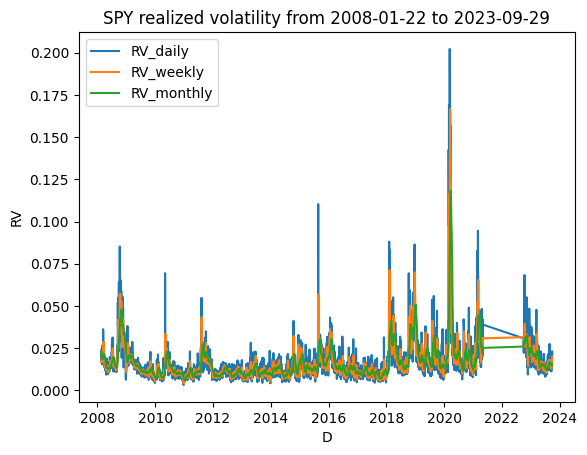

In [286]:
# Plot the RV variables.  

# uncomment the 1st line if u wanna see current data and uncomment the 2nd one if u wanna see the historical

# 1st
# curr_rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"{ticker} realized volatility from {df.index.date[0]} to {df.index.date[-1]}")

# 2nd
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"{ticker} realized volatility from {df.index.date[0]} to {df.index.date[-1]}")



plt.ylabel("RV")
plt.show()

As the volume, RVs and VIX price have significantly different ranges, we perform min-max normalization:

$X_{scaled} = \frac{X - min(X)}{max(X)-min(X)}$

In [ ]:
# Prepare data 
rv["Target"] = rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  
curr_rv["Target"] = curr_rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  

rv.dropna(inplace = True)
curr_rv.dropna(inplace = True)

#Scale the data
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())
curr_rv_scaled = (curr_rv-curr_rv.min())/(curr_rv.max()-curr_rv.min())

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)
curr_rv_scaled = sm.add_constant(curr_rv_scaled)

# MOST IMPORTANT SECTION #

This is where we will be doing the HAR-RV forecast. Adjust split date as needed. (you can change it by changing the XXX in (int(XXX * rv.shape[0])) and test it via running the cell underneath with X_test to see where your data starts / ends. If you wanna run curr data, change X_test to X_curr, and same with y_test to y_curr)

---

** MEME DATA **

I am training on historicals (2008 - 12/2020) and testing on meme era (1/2021 - 3/2021)

In [297]:

#Split train and test sets
split = int(0.905 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
X_curr = curr_rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
y_curr = curr_rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:split+60]
y_train, y_test = y[:split], y[split:split+60]

In [299]:
X_test.tail()


,const,RV_daily,RV_weekly,RV_monthly,SPY_volume
D,,,,,
2021-03-18,1.0,0.172440,0.166284,0.340534,0.003746
2021-03-19,1.0,0.191517,0.183655,0.346030,0.012543
2021-03-22,1.0,0.079695,0.177459,0.342867,0.001739
2021-03-23,1.0,0.142293,0.186815,0.344270,0.003090
2021-03-24,1.0,0.186001,0.184704,0.337508,0.003387


We can now train the parameters for HAR. $\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m + \hat{\beta_4}IV_t + \hat{\beta_5}VOL_t $ 

We do this with OLS:
$\hat{\beta} = (X'X)^{-1}X'Y$

In [300]:
results = sm.OLS(y_train, X_train).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     2153.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:47:03   Log-Likelihood:                 6352.7
No. Observations:                3237   AIC:                        -1.270e+04
Df Residuals:                    3232   BIC:                        -1.266e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.001      8.858      0.000       0.007       0.010
RV_daily       0.5224      0.021     24.780      0.000       0.481       0.564
RV_weekly      0.3294      0.024     14.002      0.000       0.283       0.375
RV_monthly    -0.0072      0.012     -0.625      0.532      -0.030       0.015
SPY_volume    -0.1580      0.051     -3.101      0.002      -0.258      -0.058
==============================================================================
Omnibus:                     2686.063   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           628573.834
Skew:                           3.071   Prob(JB):                         0.00
Kurtosis:                      70.990   Cond. No.                         86.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For $\hat{\beta_3}$ (***RV_monthly***) and $\hat{\beta_5}$ (***SPY_volume***), we do not reject the null hypothesis.  Thus, these variables are not statistically significant when making a next day forecast.

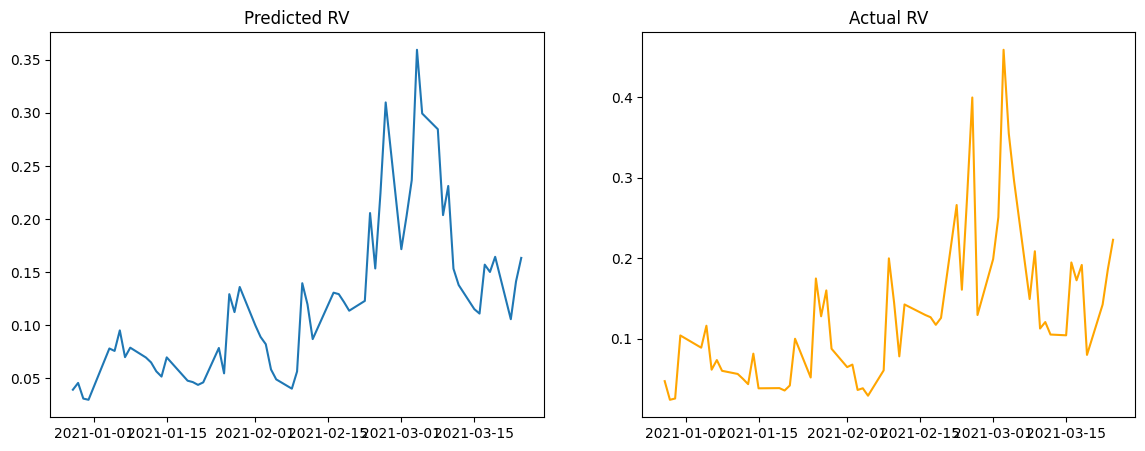

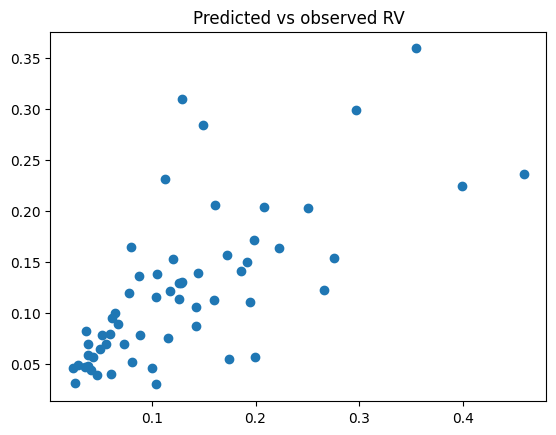

In [301]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [302]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [303]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.0011558495389458166, R^2:0.7271422843929264, MAE:0.01863677869520207
----------------
Out-of-sample scores
MSE:0.004597095847968708, R^2:0.4608131618741673, MAE:0.0456896244165643


The explanatory variables explain $59.6\%$ of the variance of the dependent variable out-of-sample.

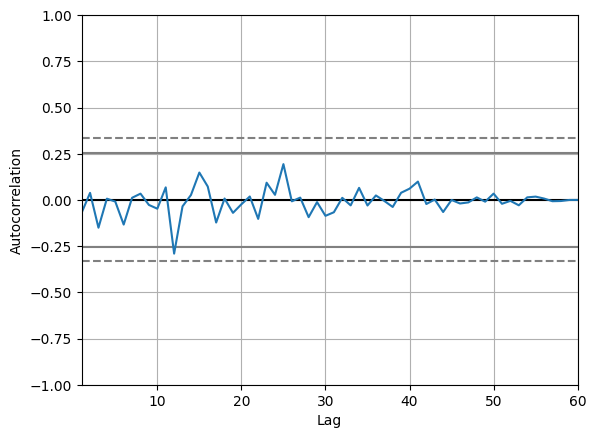

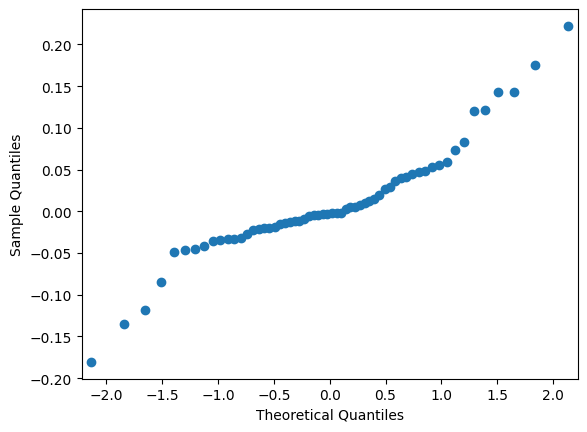

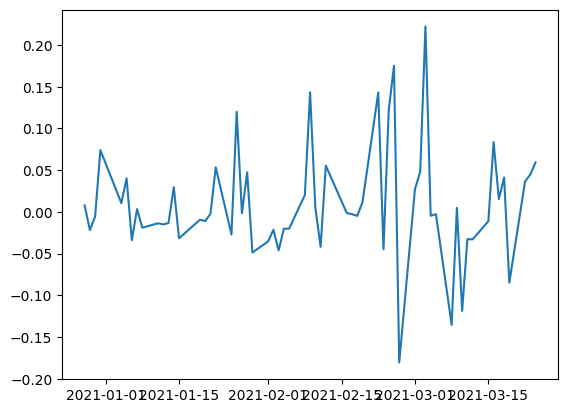

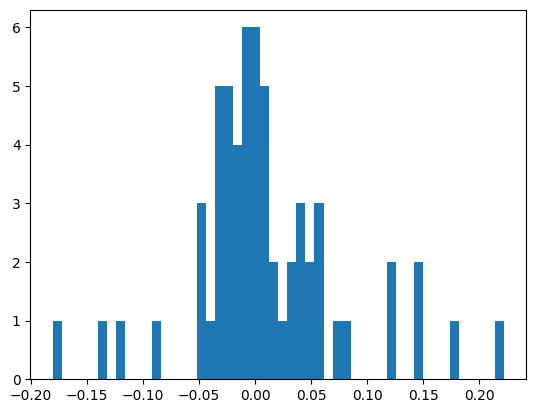

In [304]:
# Residuals
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()